In [90]:
import random

def swap_two_characters(seq):
    '''define a function that swaps two characters at random positions in a string '''
    line = list(seq)
    id_i = random.randint(0,len(line)-1)
    id_j = random.randint(0,len(line)-1)
    line[id_i], line[id_j] = line[id_j], line[id_i]
    return ''.join(line)

def one_run(length=26, depth=5):
    text = ''.join([str(unichr(97+i)) for i in range(length)])
    reference = '%s' % text
    seqs = []
    seqs.append(text)
    for i in range(depth):
        text = swap_two_characters( random.choice(seqs) )
        if text != reference:
            if text not in seqs:
                seqs.append( text )
    return seqs

def guard_seq(seq):
    return '<<'+seq+'>>'

def guard_seqs(seqs):
    return [guard_seq(seq) for seq in seqs]

def make_data(num_runs=3, trim_top=3, length=26, depth=5):
    data = list()
    for i in range(num_runs):
        random.seed(i)
        seqs = one_run(length=length, depth=depth)
        data += seqs[trim_top:]
    return guard_seqs(data)

In [91]:
import networkx as nx

def sequence_to_graph(seq):
    '''convert a sequence into a EDeN 'compatible' graph
    i.e. a graph with the attribute 'label' for every node and edge'''
    G = nx.Graph()
    for id,character in enumerate(seq):
        G.add_node(id, label = character )
        if id > 0:
            G.add_edge(id-1, id, label = '-')
    return G

def pre_process(iterable):
    for seq in iterable:
        yield sequence_to_graph(seq)

In [92]:
def extract_seq(graph, root):
    seq = []
    seq.append(graph.node[root]['label'])
    #start from root and follow links without jittering
    neighs = graph.neighbors(root)
    curr = neighs[0]
    prev = root
    seq.append(graph.node[curr]['label'])
    while True:
        neighs = graph.neighbors(curr)
        if len(neighs)== 1:
            break
        if neighs[0] == prev:
            after = neighs[1]
        else:
            after = neighs[0]
        curr, prev = after, curr
        seq.append(graph.node[curr]['label'])
    return ''.join(seq)

def extract_label_sequence(graph):
    boundaries=list()
    for u in graph.nodes():
        if len(graph.neighbors(u))==1:
            boundaries.append(u)
    assert(len(boundaries)==2)
    seq1 = extract_seq(graph, boundaries[0])
    seq2 = extract_seq(graph, boundaries[1])
    if seq1 < seq2:
        return seq1
    else:
        return seq2

----

In [117]:
length=8
ref = ''.join([str(unichr(97+i)) for i in range(length)])
ref = guard_seq(ref)
seqs = make_data(num_runs=500, trim_top=2, length=length, depth=length)
graphs = list(pre_process(seqs))

In [118]:
print ref
print len(seqs)
for seq in seqs: print seq,

<<abcdefgh>>
2842
<<abcedfgh>> <<abecdfgh>> <<abcehfgd>> <<abcgdfeh>> <<abdehfgc>> <<abcgdhef>> <<abcgefdh>> <<gbcaefdh>> <<ahcgefdb>> <<abchefdg>> <<abcdegfh>> <<abedcgfh>> <<aecdbgfh>> <<abcgedfh>> <<abcghdfe>> <<ebadcgfh>> <<abdcefgh>> <<fbedcagh>> <<abgdefch>> <<abchefgd>> <<abcfehgd>> <<abcdegfh>> <<abcdgfeh>> <<abedcfgh>> <<bacdefgh>> <<bcadefgh>> <<bacdegfh>> <<abcdehfg>> <<abchefgd>> <<gbcdehfa>> <<aecdbhfg>> <<bachefgd>> <<abcdeghf>> <<afcdegbh>> <<fbcdeagh>> <<abdgefch>> <<fbcedagh>> <<aedgbfch>> <<fbgedach>> <<abedcfgh>> <<ebcdafgh>> <<gfcdebah>> <<afcdehgb>> <<ebchafgd>> <<abgdefch>> <<hacdefgb>> <<hfcdeagb>> <<gbcdefah>> <<chadefgb>> <<hacbefgd>> <<abhdefgc>> <<ecbdafgh>> <<dcbaefgh>> <<ecbfadgh>> <<bacdefgh>> <<dcbahfge>> <<bacfedgh>> <<adcebfgh>> <<ahcdefgb>> <<ghcdefab>> <<ahdcefgb>> <<ghcfedab>> <<gacdefhb>> <<abcdfegh>> <<cbadfegh>> <<abcdegfh>> <<cfadbegh>> <<ebcdafgh>> <<abcdegfh>> <<cbadfegh>> <<adcbefgh>> <<gdcbefah>> <<abfdecgh>> <<fbcdegah>> <<aecdbfgh>> <<abcge

In [119]:
%%time
from graphlearn.graphlearn import  Sampler
from graphlearn.estimate import OneClassEstimator
from eden.graph import Vectorizer
sampler=Sampler(radius_list=[0], thickness_list=[2], random_state=2,
                min_cip_count=1, min_interface_count=1,
                vectorizer=Vectorizer(3, positional=True),
                estimator=OneClassEstimator(nu=.3, cv=5, n_jobs=-1))
sampler.fit(graphs)

CPU times: user 39.5 s, sys: 9.24 s, total: 48.7 s
Wall time: 1min 30s


In [120]:
# sample parameters
n_steps=50 # how many steps
n_samples=2 # collect this many samples during the process

gen_graphs = sampler.sample(graphs,
                        n_steps=n_steps, n_samples=n_samples,
                        target_orig_cip=False,
                        probabilistic_core_choice=False,
                        score_core_choice= False,
                        max_size_diff=0,
                        burnin=10,
                        include_seed=False,
                        proposal_probability = False,
                        improving_threshold=.1, 
                        improving_linear_start=0.0,
                        accept_static_penalty=0.0,
                        n_jobs=1,
                        select_cip_max_tries=200,
                        keep_duplicates=False,  
                        monitor=False)

In [121]:
%%time
from itertools import islice
scores=[]
similarities=[]
gen_seqs=[]
print ref
print
ref_graph = sequence_to_graph(ref)
for graph in islice(gen_graphs,200):
    if len(graph):
        score = graph[0].graph['score']
        if score > .01:
            seq = extract_label_sequence(graph[0])
            sims = Vectorizer(3).similarity([graph[0]], ref_instance=ref_graph)
            sim = sims.next()
            if seq == ref:
                mark = '*'
            else:
                mark = ''
            print '%s %s %.2f %.3f' % (mark, seq, sim, score)
            similarities.append(sim)
            scores.append(score)
            gen_seqs.append(seq)

<<abcdefgh>>

 <<ebchafgd>> 0.22 0.014
 <<adcbegfh>> 0.29 0.022
 <<bachgfed>> 0.30 0.014
 <<dbcaehgf>> 0.25 0.012
CPU times: user 2min 3s, sys: 713 ms, total: 2min 4s
Wall time: 2min 7s


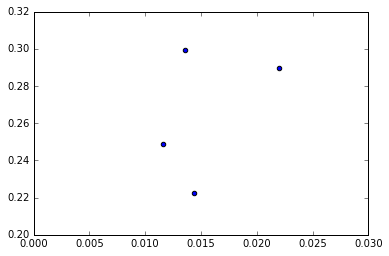

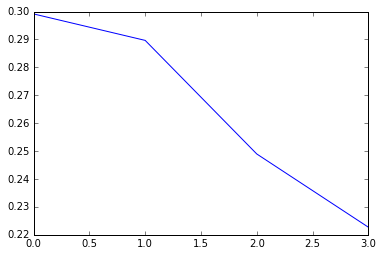

In [122]:
%matplotlib inline
import pylab as plt
plt.scatter(scores, similarities)
plt.show()
plt.plot(sorted(similarities, reverse=True))
plt.show()

In [123]:
print ref
print
for score, seq in sorted([(score, seq) for score, seq in zip(scores, gen_seqs)], reverse=True):
    print '%.3f %s'%(score, seq)

<<abcdefgh>>

0.022 <<adcbegfh>>
0.014 <<ebchafgd>>
0.014 <<bachgfed>>
0.012 <<dbcaehgf>>


---